Custom-Built CNN model on the HAM10000 dataset

In [72]:
import os
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import json
import seaborn as sns


In [70]:
model_path = 'C:/THESIS/models/goedetrained_model.h5'  
model = tf.keras.models.load_model(model_path)
print("Model geladen van:", model_path)

Model geladen van: C:/THESIS/models/goedetrained_model.h5


In [58]:
# path to the balanced HAM10000 dataset 
test_dir = 'C:/THESIS/HAM10000_balanced_nv_mel_equal_gender' 
metadata_file = 'C:/THESIS/HAM10000_balanced_nv_mel_equal_gender/HAM10000_filtered_metadata.csv'

In [60]:
# ImageDataGenerator for testset
test_datagen = ImageDataGenerator(rescale=1./255)


test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),  
    batch_size=32,
    class_mode='binary',
    shuffle=False  
)

Found 1696 images belonging to 2 classes.


In [62]:
# Evaluation of the model on the HAM10000 datast
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

C:\Users\mmmsc\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


53/53 ━━━━━━━━━━━━━━━━━━━━ 17s 303ms/step - accuracy: 0.7616 - loss: 0.4971
Test Loss: 0.46849045157432556
Test Accuracy: 0.7895047068595886


In [74]:
y_true = test_generator.classes
y_pred_proba = model.predict(test_generator).ravel()  
y_pred = (y_pred_proba > 0.5).astype("int32")  

# 7. Confusionmatrix
conf_matrix = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", conf_matrix)

# 8. Classificatiion rapport 
print("Classification Report:\n", classification_report(y_true, y_pred, target_names=['Benign', 'Malignant']))

53/53 ━━━━━━━━━━━━━━━━━━━━ 15s 274ms/step
Confusion Matrix:
 [[583 265]
 [ 92 756]]
Classification Report:
               precision    recall  f1-score   support

      Benign       0.86      0.69      0.77       848
   Malignant       0.74      0.89      0.81       848

    accuracy                           0.79      1696
   macro avg       0.80      0.79      0.79      1696
weighted avg       0.80      0.79      0.79      1696



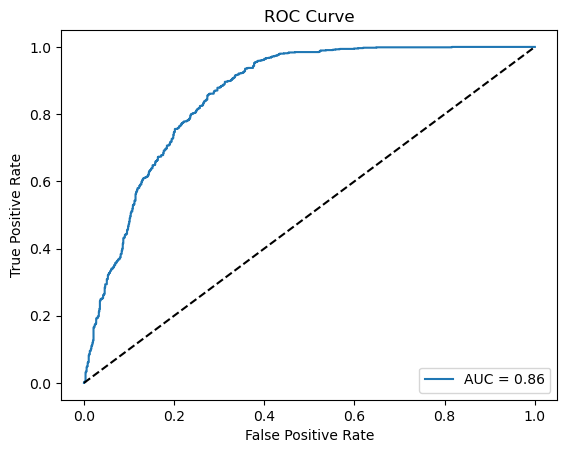

AUC-ROC: 0.86


In [66]:
# AUC-ROC curve
roc_auc = roc_auc_score(y_true, y_pred_proba)
fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)

plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], 'k--')  
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()
print(f"AUC-ROC: {roc_auc:.2f}")

In [76]:
# Gender (male and female) performance
# load metadata
metadata = pd.read_csv(metadata_file)
metadata['true_labels'] = metadata['dx'].map({'nv': 0, 'mel': 1})  # Map 'nv' to 0 (Benign) and 'mel' to 1
metadata['predictions'] = y_pred  # Voeg voorspellingen toe aan de metadata

# performance for gender
results_by_gender = {}
for gender in ['male', 'female']:
    gender_data = metadata[metadata['sex'] == gender]
    true_labels = gender_data['true_labels']
    predictions = gender_data['predictions']

    # Confusionmatrix and classification rapport
    conf_matrix = confusion_matrix(true_labels, predictions)
    report = classification_report(true_labels, predictions, target_names=['Benign', 'Malignant'], output_dict=True)

    results_by_gender[gender] = {
        'confusion_matrix': conf_matrix,
        'classification_report': report
    }
    print(f"\nPerformance for {gender.capitalize()} Patients:")
    print("Confusion Matrix:\n", conf_matrix)
    print("Classification Report:\n", classification_report(true_labels, predictions, target_names=['Benign', 'Malignant']))


Performance for Male Patients:
Confusion Matrix:
 [[246 178]
 [ 21 403]]
Classification Report:
               precision    recall  f1-score   support

      Benign       0.92      0.58      0.71       424
   Malignant       0.69      0.95      0.80       424

    accuracy                           0.77       848
   macro avg       0.81      0.77      0.76       848
weighted avg       0.81      0.77      0.76       848


Performance for Female Patients:
Confusion Matrix:
 [[337  87]
 [ 71 353]]
Classification Report:
               precision    recall  f1-score   support

      Benign       0.83      0.79      0.81       424
   Malignant       0.80      0.83      0.82       424

    accuracy                           0.81       848
   macro avg       0.81      0.81      0.81       848
weighted avg       0.81      0.81      0.81       848



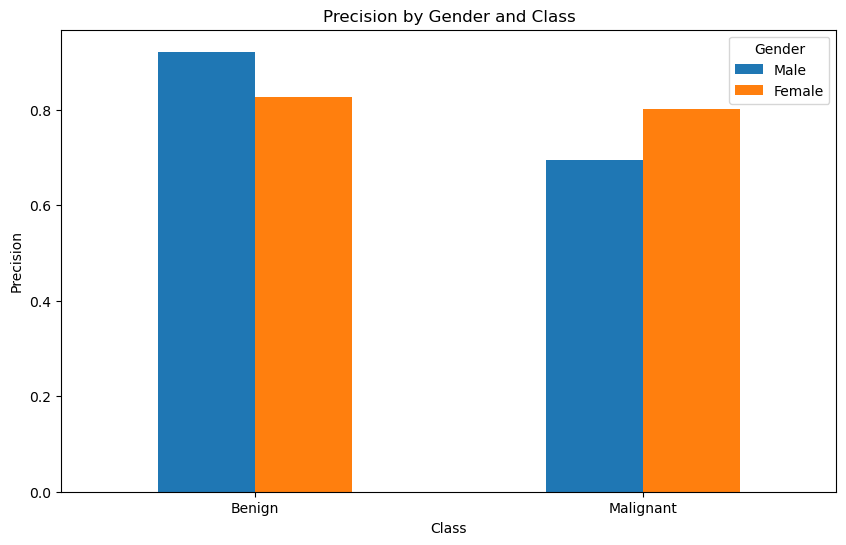

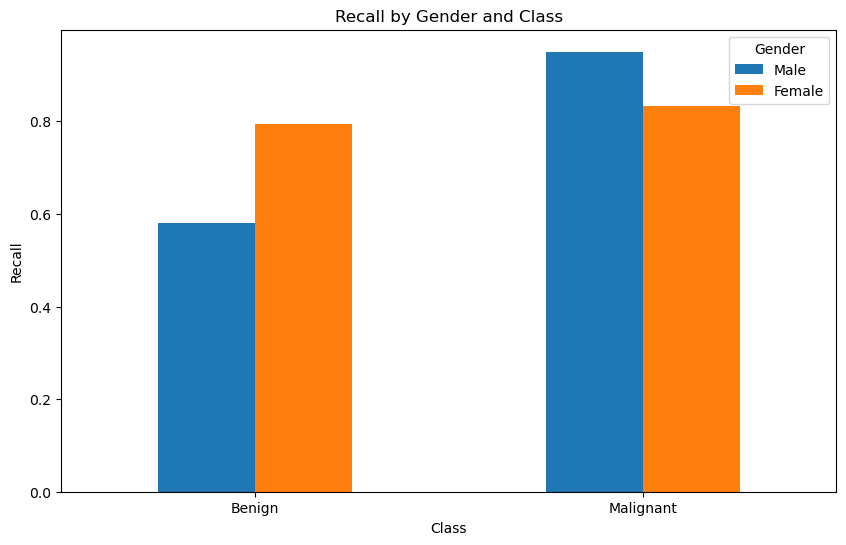

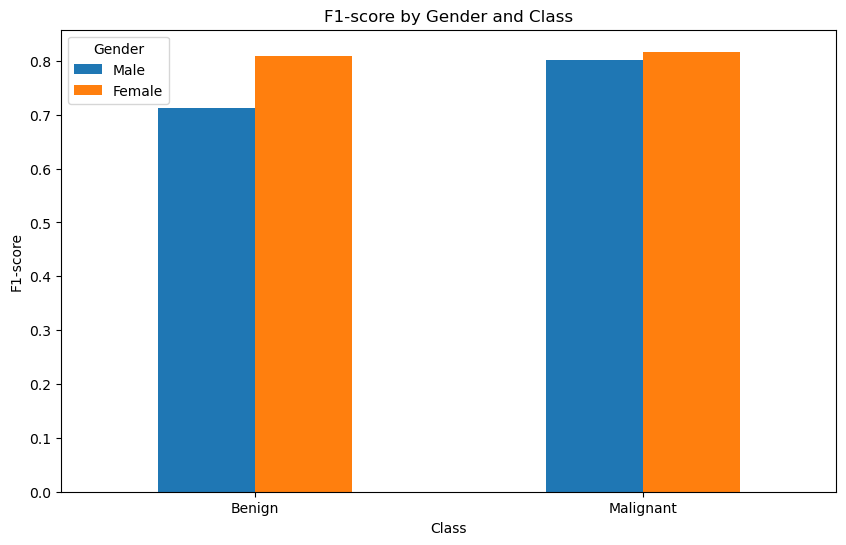

In [78]:
# Plots for quick overview
metrics = ['precision', 'recall', 'f1-score']
classes = ['Benign', 'Malignant']
gender_metrics = {metric: {gender: [] for gender in ['male', 'female']} for metric in metrics}

for gender in results_by_gender:
    for metric in metrics:
        for cls in classes:
            gender_metrics[metric][gender].append(results_by_gender[gender]['classification_report'][cls][metric])

for metric in metrics:
    data = pd.DataFrame(gender_metrics[metric], index=classes)
    data.plot(kind='bar', figsize=(10, 6))
    plt.title(f"{metric.capitalize()} by Gender and Class")
    plt.ylabel(metric.capitalize())
    plt.xlabel("Class")
    plt.xticks(rotation=0)
    plt.legend(title="Gender", labels=['Male', 'Female'])
    plt.show()

In [80]:
for gender in ['male', 'female']:
    
    gender_data = metadata[metadata['sex'] == gender]
    true_labels = gender_data['true_labels'].values
    predictions = gender_data['predictions'].values
    probabilities = y_pred_proba[gender_data.index] 

    # AUC-ROC
    auc_score = roc_auc_score(true_labels, probabilities)
    fpr, tpr, thresholds = roc_curve(true_labels, probabilities)
    print(f"AUC for {gender.capitalize()} Patients: {auc_score:.2f}")

AUC for Male Patients: 0.85
AUC for Female Patients: 0.89



Confusion Matrix for Male Patients:
[[246 178]
 [ 21 403]]
AUC for Male Patients: 0.85


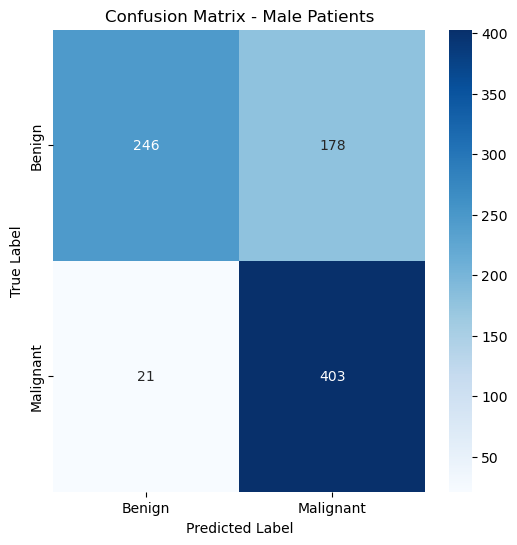

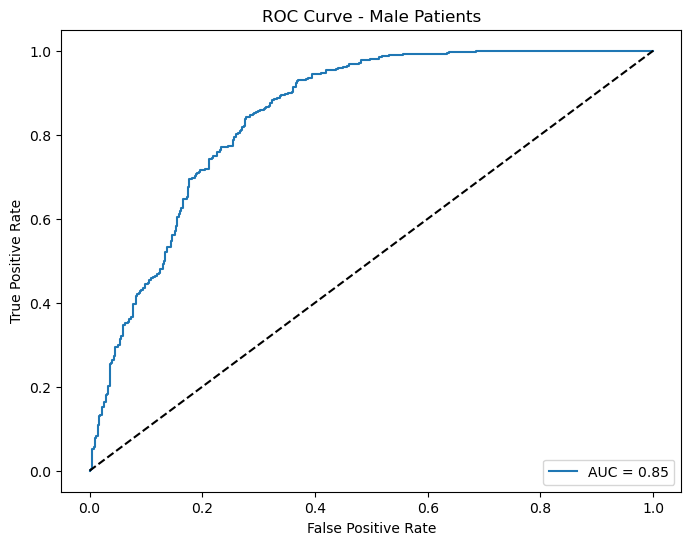


Confusion Matrix for Female Patients:
[[337  87]
 [ 71 353]]
AUC for Female Patients: 0.89


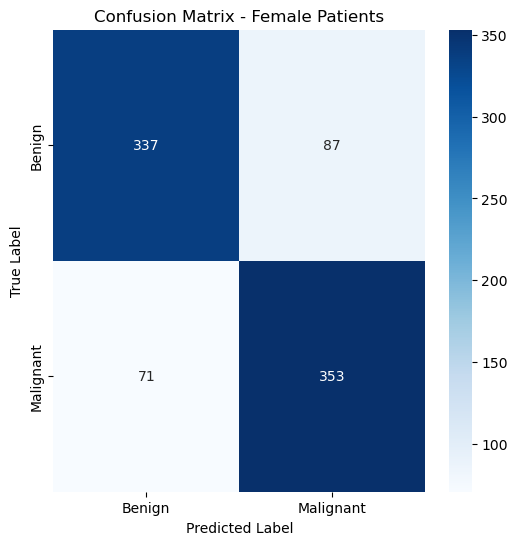

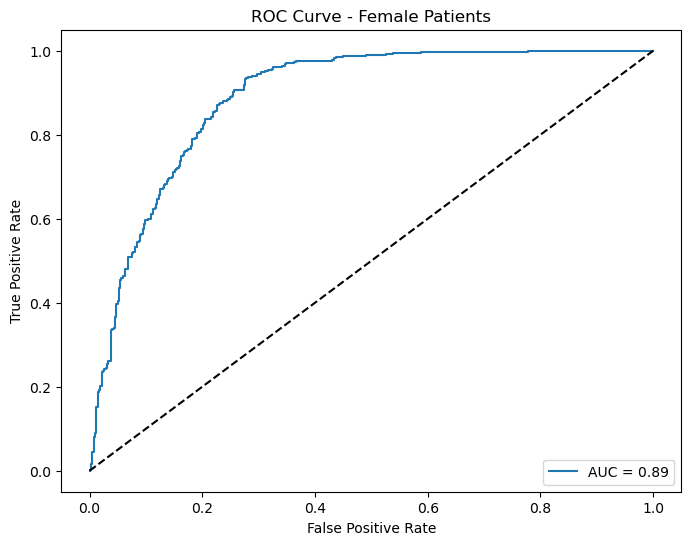

In [82]:
# Gender performance with small and big confusion matrix and AUC-ROC score
for gender in ['male', 'female']:
    
    gender_data = metadata[metadata['sex'] == gender]
    true_labels = gender_data['true_labels'].values
    predictions = gender_data['predictions'].values
    probabilities = y_pred_proba[gender_data.index]  # Gebruik indexen om bijbehorende voorspellingen te pakken

    # Confusion Matrix
    conf_matrix_gender = confusion_matrix(true_labels, predictions)
    print(f"\nConfusion Matrix for {gender.capitalize()} Patients:")
    print(conf_matrix_gender)

    # AUC-ROC
    auc_score = roc_auc_score(true_labels, probabilities)
    fpr, tpr, thresholds = roc_curve(true_labels, probabilities)
    print(f"AUC for {gender.capitalize()} Patients: {auc_score:.2f}")

    # Plot Confusion Matrix
    plt.figure(figsize=(6, 6))
    sns.heatmap(conf_matrix_gender, annot=True, fmt='d', cmap='Blues', xticklabels=['Benign', 'Malignant'], yticklabels=['Benign', 'Malignant'])
    plt.title(f"Confusion Matrix - {gender.capitalize()} Patients")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

    # Plot ROC Curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f"AUC = {auc_score:.2f}")
    plt.plot([0, 1], [0, 1], 'k--')  # Diagonale lijn voor een random classifier
    plt.title(f"ROC Curve - {gender.capitalize()} Patients")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc="lower right")
    plt.show()